# Importing Packages

In [7]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications import MobileNetV2

%reload_ext autoreload
%autoreload 2
from utils import *

# Generating Datasets

In [2]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


# Creating labels file

In [3]:
# create labels.txt file that will hold all our labels for Flutter
print(train_generator.class_indices) 
labels = '\n'.join(sorted(train_generator.class_indices.keys())) 
with open('labels.txt', 'w') as f: 
    f.write(labels)


{'mel': 0, 'not_mel': 1}


# Creating Tensorflow Lite Model

## Construct Model

In [4]:
# create base model for transfer learning
base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False, 
    weights = 'imagenet'
)

In [5]:
# freezes all neurons for base model
base_model.trainable = False 
# construct model
model = Sequential([ 
    base_model,
    Conv2D(32, 3, activation = 'relu'), 
    Dropout(0.2), 
    GlobalAveragePooling2D(), 
    Dense(1, activation = 'sigmoid')
])

## Compile Model, Define Callbacks

In [11]:
# compile model
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 0.001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [14]:
# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_mobilenet/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_mobilenet/log.csv')
log_dir = "../logs/log_mobilenet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Train Model

In [15]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/20
427/427 [==============================] - 1421s 3s/step - loss: 0.2356 - accuracy: 0.9220 - precision: 0.9260 - recall: 0.9753 - auc: 0.9412 - auc_1: 0.9699 - val_loss: 0.1479 - val_accuracy: 0.9495 - val_precision: 0.9500 - val_recall: 0.9938 - val_auc: 0.9581 - val_auc_1: 0.9925

Epoch 00001: saving model to ../logs/log_mobilenet/model.01-0.15.hdf5
Epoch 2/20
427/427 [==============================] - 1574s 4s/step - loss: 0.1251 - accuracy: 0.9556 - precision: 0.9553 - recall: 0.9878 - auc: 0.9795 - auc_1: 0.9909 - val_loss: 0.1525 - val_accuracy: 0.9441 - val_precision: 0.9663 - val_recall: 0.9692 - val_auc: 0.9575 - val_auc_1: 0.9923

Epoch 00002: saving

## Evaluate Model

In [10]:
history = pd.read_csv("../logs/log_mobilenet/log.csv")
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.937134,0.964155,0.982928,0.177265,0.001000,0.938040,0.982287,0.949468,0.958054,0.992547,0.147887,0.950000,0.993846
1,1,0.957943,0.980760,0.991104,0.120084,0.001000,0.958341,0.987678,0.944149,0.957541,0.992319,0.152525,0.966258,0.969231
2,2,0.965563,0.986931,0.994155,0.099192,0.001000,0.964942,0.990760,0.948138,0.938997,0.982792,0.153424,0.963636,0.976959
3,3,0.968494,0.989859,0.995423,0.084597,0.001000,0.967675,0.991718,0.949468,0.958401,0.990816,0.144011,0.965046,0.976923
4,4,0.978019,0.995032,0.997830,0.061098,0.000500,0.975835,0.995762,0.964096,0.941810,0.983465,0.147830,0.965620,0.993846
5,5,0.980803,0.996239,0.998491,0.054188,0.000500,0.979731,0.995381,0.944149,0.954487,0.989371,0.152407,0.969136,0.966154
6,6,0.982122,0.997895,0.999315,0.046148,0.000500,0.980496,0.996344,0.965426,0.935830,0.981636,0.156686,0.968468,0.992308
7,7,0.985492,0.997811,0.999153,0.041379,0.000500,0.983118,0.998074,0.952128,0.937677,0.983090,0.175646,0.970859,0.973846
8,8,0.986958,0.998437,0.999372,0.036882,0.000500,0.985546,0.997498,0.957447,0.918914,0.975808,0.229965,0.961194,0.990769
9,9,0.986225,0.999223,0.999752,0.031986,0.000500,0.984779,0.997303,0.960106,0.927781,0.978777,0.182636,0.968326,0.986175


In [11]:
plt.style.use("ggplot")
sixplot(history, "auc", "val_auc", "auc_1", "val_auc_1", "precision", "val_precision", "recall", "val_recall")

AttributeError: 'DataFrame' object has no attribute 'history'

In [19]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1,lr
0,0.177265,0.937134,0.938040,0.982287,0.964155,0.982928,0.147887,0.949468,0.950000,0.993846,0.958054,0.992547,0.001000
1,0.120084,0.957943,0.958341,0.987678,0.980760,0.991104,0.152525,0.944149,0.966258,0.969231,0.957541,0.992319,0.001000
2,0.099192,0.965563,0.964942,0.990760,0.986931,0.994155,0.153424,0.948138,0.963636,0.976959,0.938997,0.982792,0.001000
3,0.084597,0.968494,0.967675,0.991718,0.989859,0.995423,0.144011,0.949468,0.965046,0.976923,0.958401,0.990816,0.001000
4,0.061098,0.978019,0.975835,0.995762,0.995032,0.997830,0.147830,0.964096,0.965620,0.993846,0.941810,0.983465,0.000500
5,0.054188,0.980803,0.979731,0.995381,0.996239,0.998491,0.152407,0.944149,0.969136,0.966154,0.954487,0.989371,0.000500
6,0.046148,0.982122,0.980496,0.996344,0.997895,0.999315,0.156686,0.965426,0.968468,0.992308,0.935830,0.981636,0.000500
7,0.041379,0.985492,0.983118,0.998074,0.997811,0.999153,0.175646,0.952128,0.970859,0.973846,0.937677,0.983090,0.000500
8,0.036882,0.986958,0.985546,0.997498,0.998437,0.999372,0.229965,0.957447,0.961194,0.990769,0.918914,0.975808,0.000500
9,0.031986,0.986225,0.984779,0.997303,0.999223,0.999752,0.182636,0.960106,0.968326,0.986175,0.927781,0.978777,0.000500


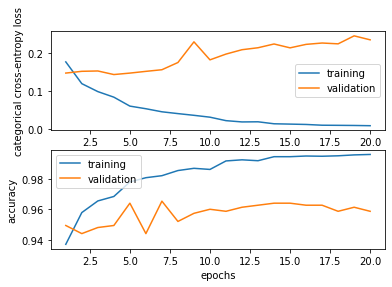

In [22]:
# visualization for loss and accuracy
train_val_metrics(20, history)  

## Save and Load Model

In [23]:
model.save('../models/mobilenet')

INFO:tensorflow:Assets written to: ../models/mobilenet/assets


In [9]:
model = load_model('../models/mobilenet')

In [14]:
model2 = load_model('../logs/log_mobilenet/model.04-0.14.hdf5')

In [16]:
## Predict on Holdout Set

753/753 [==============================] - 329s 436ms/step


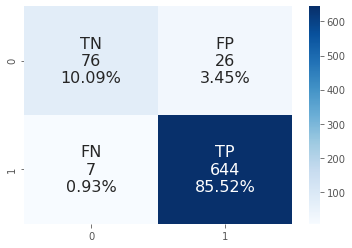

In [12]:
# display confusion matrix visualization
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

In [15]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

753/753 [==============================] - 161s 208ms/step - loss: 0.2221 - accuracy: 0.9562 - precision: 0.9612 - recall: 0.9892 - auc: 0.9247 - auc_1: 0.9779
Loss: 0.22214962542057037
Accuracy: 0.9561753273010254
Precision: 0.9611940383911133
Recall: 0.9892473220825195
ROC-AUC: 0.9247462749481201
PR-AUC: 0.9779129028320312


753/753 [==============================] - 152s 201ms/step


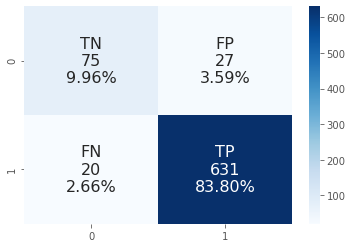

In [17]:
# display confusion matrix visualization
test_generator.reset()
pred2 = model2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred2 = pred2 > 0.5
make_confusion_matrix(y_true, y_pred2)

In [18]:
# get testing accuracy and loss
test_generator.reset()
score2 = model2.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score2[0]))
print("Accuracy: " + str(score2[1]))
print("Precision: " + str(score2[2]))
print("Recall: " + str(score2[3]))
print("ROC-AUC: " + str(score2[4]))
print("PR-AUC: " + str(score2[5]))

753/753 [==============================] - 144s 190ms/step - loss: 0.1825 - accuracy: 0.9376 - precision: 0.9590 - recall: 0.9693 - auc: 0.9380 - auc_1: 0.9845
Loss: 0.1825425624847412
Accuracy: 0.9375830292701721
Precision: 0.9589665532112122
Recall: 0.9692780375480652
ROC-AUC: 0.9379837512969971
PR-AUC: 0.9845151305198669


In [19]:
saved_model_dir = '../models/tensorlite' 
tf.saved_model.save(model, saved_model_dir) 

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f: 
  f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/tensorlite/assets
